# CSE 250A Project

Topic: Anomaly Detection in Air Quality Data

Name: Eugene Song, Kevin Wu, Yishan Cai

## Setup

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hmmlearn.hmm import GaussianHMM
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


## EDA

In [2]:
df  = pd.read_excel('AirQualityUCI.xlsx')
df.replace(-200, np.nan, inplace=True)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150.0,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88.0,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80.0,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51.0,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [3]:
df.shape

(9357, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         7674 non-null   float64       
 3   PT08.S1(CO)    8991 non-null   float64       
 4   NMHC(GT)       914 non-null    float64       
 5   C6H6(GT)       8991 non-null   float64       
 6   PT08.S2(NMHC)  8991 non-null   float64       
 7   NOx(GT)        7718 non-null   float64       
 8   PT08.S3(NOx)   8991 non-null   float64       
 9   NO2(GT)        7715 non-null   float64       
 10  PT08.S4(NO2)   8991 non-null   float64       
 11  PT08.S5(O3)    8991 non-null   float64       
 12  T              8991 non-null   float64       
 13  RH             8991 non-null   float64       
 14  AH             8991 non-null   float64       
dtypes: datetime64[ns](1),

### Data Integrity

In [5]:
# Combine Date & Time → timestamp
df['Time'] = df['Time'].astype(str)
df['Date'] = df['Date'].astype(str)

# 4. Combine & parse
df['timestamp'] = pd.to_datetime(
    df['Date'] + " " + df['Time'],
    errors='coerce'
)

df = df.set_index('timestamp').sort_index()

In [6]:
# Time continuity check
expected_freq = "1h"
missing_timestamps = pd.date_range(df.index.min(), df.index.max(), freq=expected_freq).difference(df.index)
print(f"Time gaps detected: {len(missing_timestamps)}")
if len(missing_timestamps) > 0:
    print(missing_timestamps[:10])

Time gaps detected: 0


In [7]:
missing_ratio = df.isna().mean().sort_values(ascending=False)
print("Missing Ratio (%):")
print((missing_ratio * 100).round(2))

Missing Ratio (%):
NMHC(GT)         90.23
CO(GT)           17.99
NO2(GT)          17.55
NOx(GT)          17.52
PT08.S2(NMHC)     3.91
C6H6(GT)          3.91
PT08.S1(CO)       3.91
PT08.S5(O3)       3.91
T                 3.91
PT08.S3(NOx)      3.91
PT08.S4(NO2)      3.91
RH                3.91
AH                3.91
Date              0.00
Time              0.00
dtype: float64


In [8]:
# Column with high missing value ratio: delete whole column
df.drop(columns=['NMHC(GT)'], inplace=True)

# Column with low missing value ratio: linear interpolate
sensor_cols = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
               'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'C6H6(GT)']
for col in sensor_cols:
    df[col] = df[col].interpolate(method='linear').ffill().bfill()

# Column with mid missing value ratio: linear regression
# Map each ground truth pollutant (GT) to its corresponding sensor
# These sensors measure the same pollutant but with different accuracy
# We'll use sensor readings to predict missing GT values
pollutant_sensor_map = {
    'CO(GT)': 'PT08.S1(CO)',   
    'NOx(GT)': 'PT08.S3(NOx)',
    'NO2(GT)': 'PT08.S4(NO2)'
}

def impute_pollutants_with_sensors(df, pollutant_sensor_map, additional_features=['T', 'RH']):
    df = df.copy()
    
    for pollutant, sensor in pollutant_sensor_map.items():
        train_mask = df[pollutant].notna() & df[sensor].notna()
        test_mask = df[pollutant].isna() & df[sensor].notna()
    
        feature_cols = [sensor] + [f for f in additional_features if f in df.columns]
        
        train_data_complete = train_mask.copy()
        test_data_complete = test_mask.copy()
        
        X_train = df.loc[train_data_complete, feature_cols].values
        y_train = df.loc[train_data_complete, pollutant].values
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        if test_data_complete.sum() > 0:
            X_test = df.loc[test_data_complete, feature_cols].values
            predictions = model.predict(X_test)
            predictions = np.maximum(predictions, 0)
            df.loc[test_data_complete, pollutant] = predictions
        
    return df

df = impute_pollutants_with_sensors(df, pollutant_sensor_map)


In [9]:
df.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.085745,1102.932925,10.178838,942.019562,238.063267,832.634930,111.029765,1453.172887,1032.422456,18.231754,49.189157,1.019621
std,1.415269,218.201561,7.503295,267.864854,200.936763,255.708807,45.538562,343.201361,404.442611,8.782368,17.194081,0.402203
min,0.000000,647.250000,0.149048,383.250000,0.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,1.000000,937.500000,4.477145,736.000000,99.000000,654.000000,78.985429,1227.000000,733.250000,11.725000,35.800000,0.732280
50%,1.800000,1066.750000,8.289085,910.333333,182.000000,803.500000,107.000000,1459.500000,970.000000,17.575000,49.650000,0.989504
75%,2.800000,1238.750000,14.096486,1119.000000,313.300000,967.500000,136.000000,1668.250000,1293.000000,24.275001,62.250002,1.306671
max,11.900000,2039.750000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


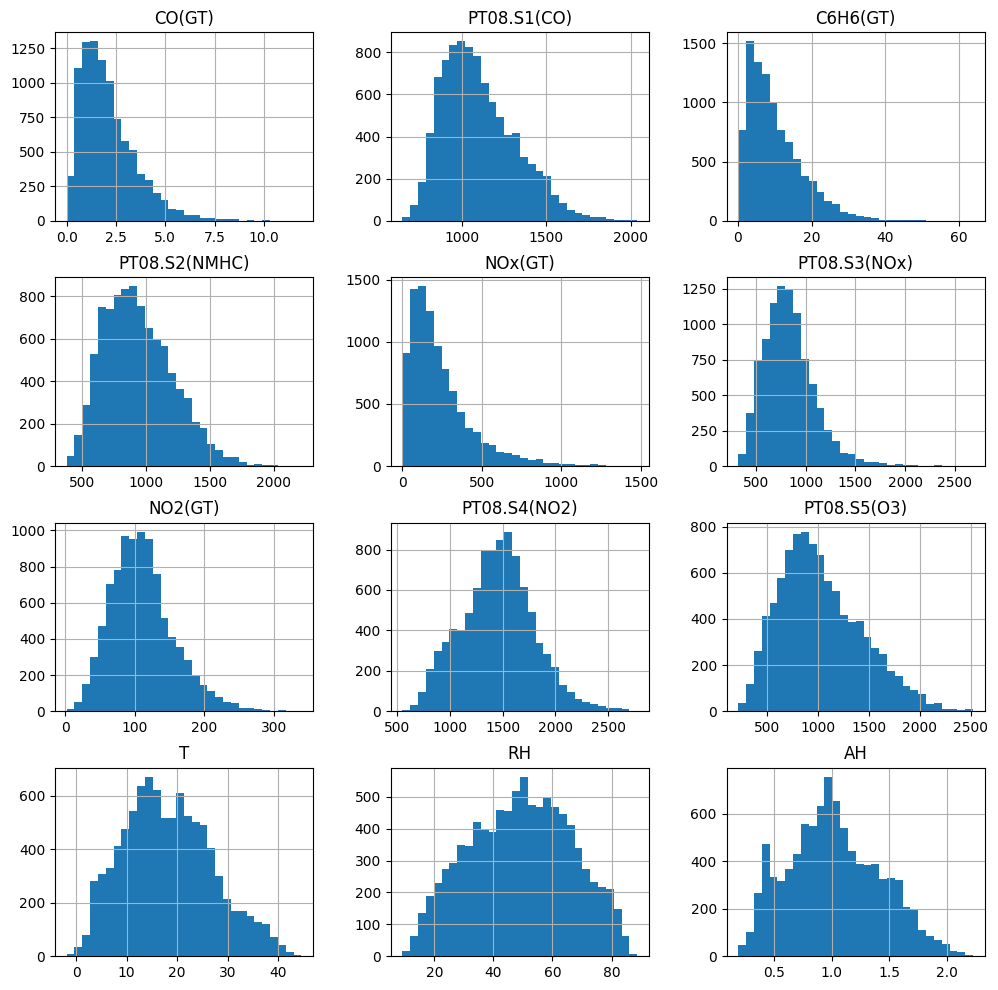

In [10]:
df.hist(figsize=(12, 12), bins=30)
plt.show()

### Trend Analysis

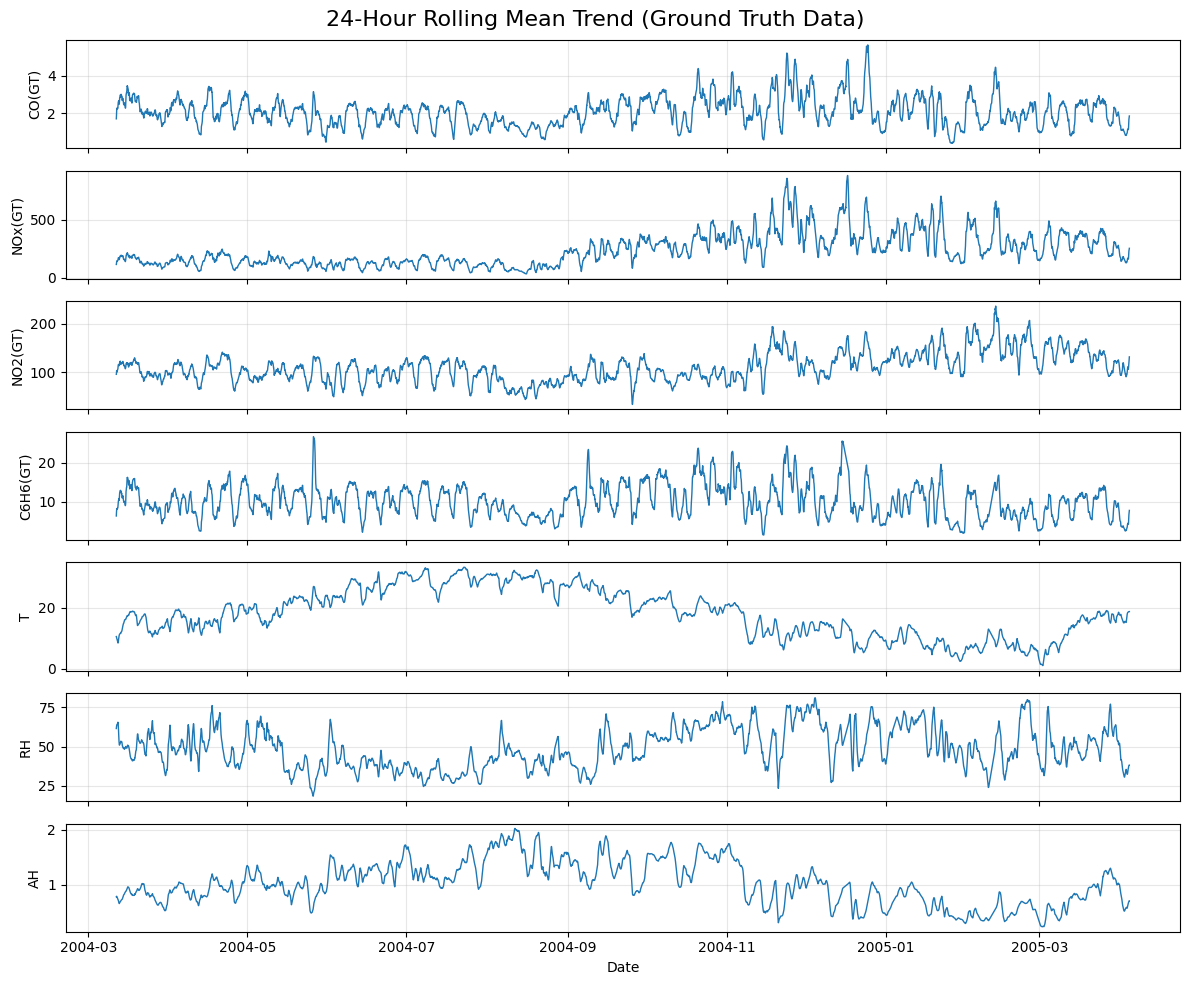

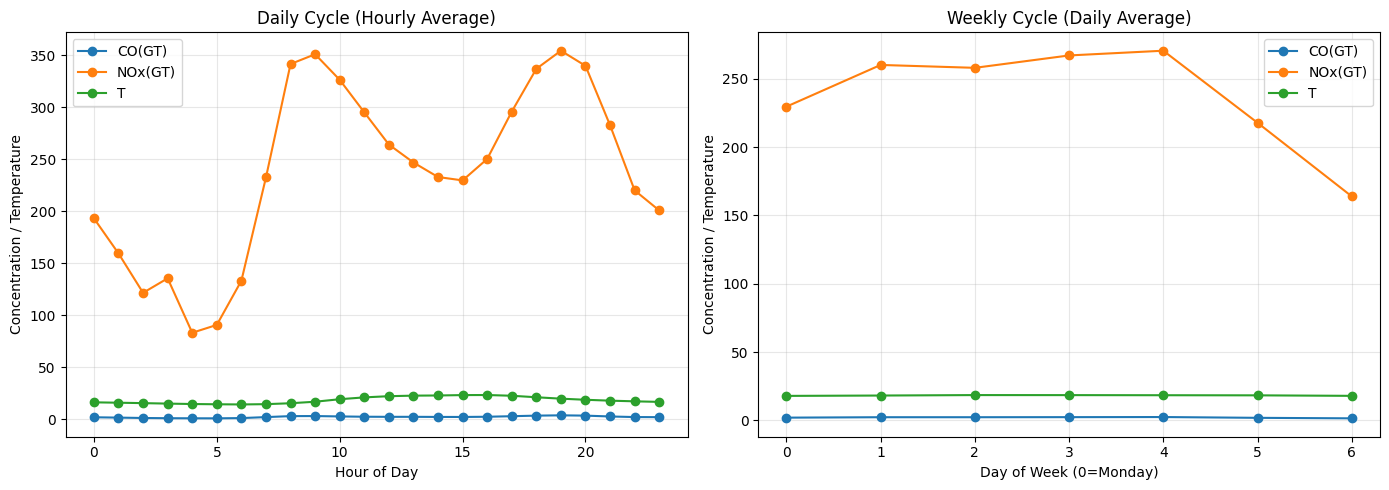

In [11]:
# Use Ground Truth data for trend analysis (actual concentrations)
pollutant_cols = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']  # C6H6 = Benzene
environmental_cols = ['T', 'RH', 'AH']

# Rolling mean for trend & seasonality visualization
df_rolling = df[pollutant_cols + environmental_cols].rolling(24).mean()

fig, axes = plt.subplots(len(pollutant_cols + environmental_cols), 1, 
                         figsize=(12, 10), sharex=True)
for i, col in enumerate(pollutant_cols + environmental_cols):
    axes[i].plot(df_rolling.index, df_rolling[col], linewidth=1)
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)

plt.suptitle("24-Hour Rolling Mean Trend (Ground Truth Data)", fontsize=16)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# Daily/Weekly seasonal profiles
daily_profile = df[pollutant_cols + environmental_cols].groupby(df.index.hour).mean()
weekly_profile = df[pollutant_cols + environmental_cols].groupby(df.index.dayofweek).mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

daily_profile[pollutant_cols[:2] + ['T']].plot(ax=axes[0], marker='o')
axes[0].set_title("Daily Cycle (Hourly Average)")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Concentration / Temperature")
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

weekly_profile[pollutant_cols[:2] + ['T']].plot(ax=axes[1], marker='o')
axes[1].set_title("Weekly Cycle (Daily Average)")
axes[1].set_xlabel("Day of Week (0=Monday)")
axes[1].set_ylabel("Concentration / Temperature")
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## HMM Modeling

In [21]:
# Feature engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Select features for HMM
hmm_features = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH']
X = df[hmm_features].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# monthly_models = {}
# for month in range(1, 13):
#     X_month = X_scaled[df['month'] == month]
#     model = GaussianHMM(n_components=4, covariance_type='diag', n_iter=100, random_state=42)
#     model.fit(X_month)
#     monthly_models[month] = model

In [22]:
# Define Gaussian HMM
n_states = 4 # initial state num
model = GaussianHMM(n_components=n_states, covariance_type='full', n_iter=100, random_state=42, verbose=True)

### Baum–Welch Training

In [23]:
model.fit(X_scaled)

         1  -54017.44433092             +nan
         2  -46367.57202800   +7649.87230292
         3  -42687.80223829   +3679.76978971
         4  -40979.49181410   +1708.31042419
         5  -40268.42385990    +711.06795420
         6  -39765.98219556    +502.44166434
         7  -39428.92059636    +337.06159921
         8  -39181.30269460    +247.61790176
         9  -38932.40390418    +248.89879042
        10  -38697.34187728    +235.06202689
        11  -38523.19870891    +174.14316837
        12  -38387.66616326    +135.53254565
        13  -38279.06458543    +108.60157783
        14  -38182.66349625     +96.40108918
        15  -38113.66435086     +68.99914539
        16  -38060.44245926     +53.22189161
        17  -38018.35712191     +42.08533735
        18  -37971.50644679     +46.85067511
        19  -37916.30254603     +55.20390076
        20  -37787.86259126    +128.43995477
        21  -37604.14904524    +183.71354602
        22  -37478.48980911    +125.65923613
        23

,n_components,4
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


After fitting the Gaussian HMM using the Baum–Welch algorithm, the log-likelihood of the model steadily increased and eventually stabilized, indicating that the EM procedure successfully converged. The final trained model includes estimated parameters for the hidden state transition matrix, emission means, emission covariances, and initial state probabilities. These parameters capture the underlying latent pollution regimes in the dataset.

The convergence behavior, visible from the diminishing changes in log-likelihood across iterations, demonstrates that the model has reached a stable solution. This trained HMM can now be used for inference, including decoding the most likely sequence of hidden states with the Viterbi algorithm and computing posterior state probabilities, which form the basis for analyzing temporal patterns and detecting anomalies in air quality.

In [24]:
best_model = None
best_loglik = -np.inf
n_restarts = 5

for i in range(n_restarts):
    model = GaussianHMM(
        n_components=4,
        covariance_type='full',
        n_iter=100,
        tol=0.01,
        random_state=i,
        verbose=False
    )
    model.fit(X_scaled)
    loglik = model.score(X_scaled)
    if loglik > best_loglik:
        best_loglik = loglik
        best_model = model

print("Best log-likelihood:", best_loglik)

Best log-likelihood: -37118.746719189214


The best log-likelihood achieved across multiple random initializations was -37118.75. The negative value is expected because the log-likelihood is the sum of the logarithms of probability densities, which are between 0 and 1. The model with the highest log-likelihood was selected as the final trained HMM.

### Transition matrix

In [40]:
# Transition matrix
print("Transition Matrix:")
print(pd.DataFrame(best_model.transmat_, 
                   columns=[f'State {i}' for i in range(n_states)],
                   index=[f'State {i}' for i in range(n_states)]).round(3))

# Initial state distribution
print("\nInitial State Distribution:")
print(pd.Series(best_model.startprob_, 
                index=[f'State {i}' for i in range(n_states)]).round(3))

Transition Matrix:
         State 0  State 1  State 2  State 3
State 0    0.897    0.001    0.031    0.070
State 1    0.000    0.975    0.003    0.023
State 2    0.029    0.002    0.947    0.021
State 3    0.091    0.019    0.055    0.834

Initial State Distribution:
State 0    0.0
State 1    0.0
State 2    1.0
State 3    0.0
dtype: float64


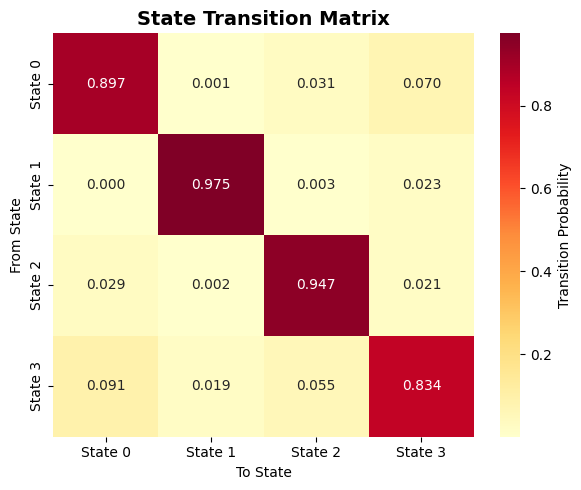

In [41]:
plt.figure(figsize=(6, 5))
sns.heatmap(best_model.transmat_, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=[f'State {i}' for i in range(n_states)],
            yticklabels=[f'State {i}' for i in range(n_states)],
            cbar_kws={'label': 'Transition Probability'})
plt.title('State Transition Matrix', fontsize=14, fontweight='bold')
plt.xlabel('To State')
plt.ylabel('From State')
plt.tight_layout()
plt.show()

### Emission means

Emission Means (standardized):
         CO(GT)  NOx(GT)  NO2(GT)      T     RH
State 0  -0.395   -0.186   -0.440  0.036  0.563
State 1  -0.287    0.152    0.526 -1.182 -0.107
State 2  -0.242   -0.649   -0.424  0.643 -0.515
State 3   1.338    1.371    0.915 -0.078  0.297


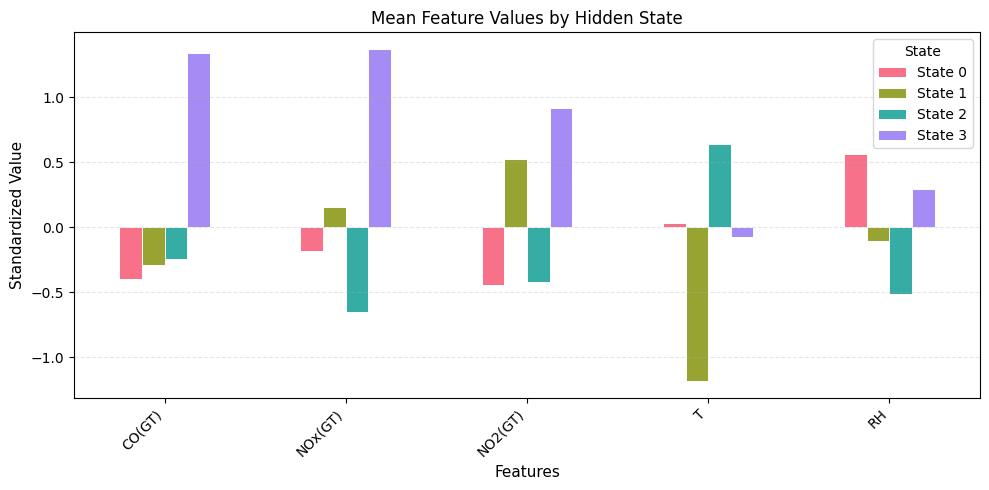

In [ ]:
means_df = pd.DataFrame(best_model.means_, 
                        columns=hmm_features,
                        index=[f'State {i}' for i in range(n_states)])
print("Emission Means (standardized):")
print(means_df.round(3))

husl_colors = sns.color_palette("husl", n_colors=n_states)

ax = means_df.T.plot(kind='bar', figsize=(10, 5), 
                     color=husl_colors,
                     title='Mean Feature Values by Hidden State',
                     edgecolor='white', linewidth=0.7)
plt.xlabel('Features', fontsize=11)
plt.ylabel('Standardized Value', fontsize=11)
plt.legend(title='State', frameon=True)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Inference

In [25]:
state_sequence = model.predict(X_scaled)
df['latent_state'] = state_sequence

In [26]:
df['latent_state'].value_counts()

latent_state
2    3404
0    2504
1    1785
3    1664
Name: count, dtype: int64

In [28]:
# model.means_ is in scaled space
means_scaled = model.means_            # (n_states, n_features)
means_orig = scaler.inverse_transform(means_scaled)  # back to original units
state_means = pd.DataFrame(means_orig, columns=hmm_features)
state_means.index = [f"State_{i}" for i in range(means_orig.shape[0])]
print(state_means)

           CO(GT)     NOx(GT)     NO2(GT)          T         RH
State_0  1.526807  200.694638   90.981281  18.550272  58.861626
State_1  1.679446  268.699147  134.973455   7.848123  47.342008
State_2  1.743292  107.730449   91.739553  23.881346  40.341788
State_3  3.979499  513.489471  152.705205  17.545424  54.292730


Based on the result above, we may derive that:

State 0 – Baseline moderate pollution
- CO ~1.53, NOx ~200, NO2 ~91
- Temperature ~18.5°C
- Humidity ~59%
- Appears to represent normal/moderate background pollution, typical of daytime or steady conditions.

State 1 – Cold & high NOx / NO2 pollution
- CO ~1.68, NOx ~270, NO2 ~135
- Temperature very low (~7.8°C)
- Likely corresponds to cold-season combustion activity, e.g.,: winter heating or stagnant nighttime air
- This is the dirtiest NOx/NO2 state, even though CO is not extreme.

State 2 – Warm & clean state
- CO ~1.74, NOx ~108, NO2 ~91
- Temperature ~24°C
- Humidity lowest (~40%)
- This looks like the cleanest state, typically summer days, high atmospheric dispersion, or lower traffic/combustion pollution.

State 3 – Severe pollution spikes
- CO ~4.0 (2× or higher than other states)
- NOx ~520, NO2 ~153 (the highest values)
- A clear severe pollution state, likely: traffic rush hour spikes, winter inversion events, or industrial plumes.


In [29]:
freq = df['latent_state'].value_counts().sort_index()
freq_norm = df['latent_state'].value_counts(normalize=True).sort_index()
print(freq)
print(freq_norm)

latent_state
0    2504
1    1785
2    3404
3    1664
Name: count, dtype: int64
latent_state
0    0.267607
1    0.190766
2    0.363792
3    0.177835
Name: proportion, dtype: float64


Proportions:
- State 0 (26.8%) — Moderate background
- State 1 (19.1%) — Cold-season high-NOx
- State 2 (36.4%) — Most common, typical warm/clean periods
- State 3 (17.8%) — Pollution spikes / heavy events

This distribution makes sense for an urban air-quality dataset.

In [30]:
state_obs_means = df.groupby('latent_state')[['CO(GT)','NOx(GT)','NO2(GT)','T','RH']].mean()
state_obs_means

,CO(GT),NOx(GT),NO2(GT),T,RH
latent_state,,,,,
0,1.545520,203.384556,91.462375,18.514529,58.987607
1,1.685876,270.071202,135.411562,7.837500,47.405256
2,1.738873,107.739777,91.641646,23.822762,40.473790
3,4.037214,522.511879,153.981923,17.518946,54.186786


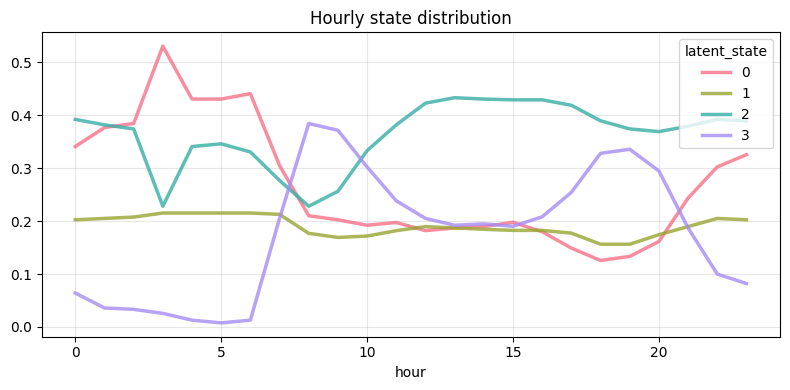

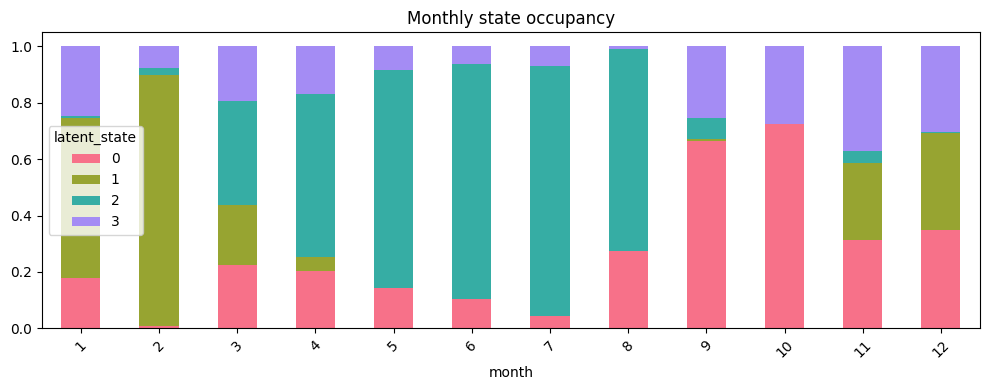

In [ ]:
# hourly profile
hourly = df.groupby('hour')['latent_state'].value_counts(normalize=True).unstack(fill_value=0)

# monthly occupancy
monthly = df.groupby('month')['latent_state'].value_counts(normalize=True).unstack(fill_value=0)

colors = sns.color_palette("husl", n_colors=hourly.shape[1])

# hourly profile
hourly.plot(kind='line', figsize=(8,4), title='Hourly state distribution', 
            color=colors, linewidth=2.5, alpha=0.8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# monthly occupancy
monthly.plot(kind='bar', stacked=True, figsize=(10,4), 
             title='Monthly state occupancy', color=colors)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the hourly state distribution plot:
- State 2 peaks in the afternoon (13:00–17:00)
→ warm, clean state aligns with sunlight-driven dispersion

- State 0 more common early morning (3:00–6:00)
→ typical low but steady emissions

- State 3 increases around 18:00–21:00
→ matches evening congestion pollution

- State 1 more common late night and early morning (midnight–6:00)
→ cold, stagnant, high-NOx winter-like behavior

From the monthly stacked bars:

- State 2 dominates warm-season months (April–August)
→ consistent with higher temperature & lower pollution

- State 1 dominates February
→ likely cold-weather pollution buildup

- State 3 increases in winter months (Nov, Dec, Jan)
→ pollution events more frequent in winter

- State 0 appears throughout but peaks in fall/winter transition

This indicates the HMM successfully extracted seasonal air-quality regimes.

In [32]:
# run-length encoding durations
states = df['latent_state'].values
runs = []
prev = states[0]
length = 1
for s in states[1:]:
    if s == prev:
        length += 1
    else:
        runs.append((prev, length))
        prev = s
        length = 1
runs.append((prev, length))
dur_df = pd.DataFrame(runs, columns=['state','duration_hours'])
dur_df.groupby('state')['duration_hours'].describe()


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
0,230.0,10.886957,15.079855,1.0,4.00,8.0,11.75,162.0
1,44.0,40.568182,55.931186,3.0,10.75,21.0,44.50,277.0
2,163.0,20.883436,21.300435,2.0,7.00,17.0,23.00,155.0
3,259.0,6.424710,5.724042,1.0,3.00,4.0,8.00,36.0
